# BOFire Reaction Optimization Example

This notebook follows the example set out in https://github.com/experimental-design/bofire/blob/main/tutorials/basic_examples/Reaction_Optimization_Example.ipynb

In [3]:
# !pip install git+https://github.com/austin-mroz/summit.git@mac-implementation gauche bofire[optimization,cheminfo] matplotlib rdkit

In [4]:
# python imports we'll need in this notebook
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import os

## Setting up the optimization problem as a Reaction Domain


In [5]:
from bofire.data_models.domain.api import Domain
from bofire.data_models.domain.api import Inputs, Outputs
from bofire.data_models.features.api import (
    ContinuousInput,
    ContinuousOutput,
    CategoricalInput,
    CategoricalDescriptorInput,
)  # we won't need all of those.

In [6]:
# We wish the temperature of the reaction to be between 30 and 110 °C
temperature_feature = ContinuousInput(
    key="Temperature", bounds=[30.0, 110.0], unit="°C"
)

# Catalyst Loading
catalyst_loading_feature = ContinuousInput(
    key="Catalyst Loading", bounds=[0.5, 2], unit="%"
)

# Residence Time
residence_time_feature = ContinuousInput(
    key="Residence Time", bounds=[1 * 60, 10 * 60], unit="minutes"
)

# Catalyst choice
catalyst_feature = CategoricalInput(
    key="Catalyst",
    categories=[
        "P1-L1",
        "P2-L1",
        "P1-L2",
        "P1-L3",
        "P1-L4",
        "P1-L5",
        "P1-L6",
        "P1-L7",
    ],
)

# gather all individual features
input_features = Inputs(
    features=[
        temperature_feature,
        catalyst_loading_feature,
        residence_time_feature,
        catalyst_feature,
    ]
)

In [7]:
# outputs: we wish to maximize the Yield
# import Maximize Objective to tell the optimizer you wish to optimize
from bofire.data_models.objectives.api import MaximizeObjective

objective = MaximizeObjective(
    w=1.0,
)
yield_feature = ContinuousOutput(key="Yield", objective=objective)
# create an output feature
output_features = Outputs(features=[yield_feature])

In [8]:
objective

MaximizeObjective(type='MaximizeObjective', w=1.0, bounds=(0, 1))

In [9]:
# we now have
print("input_features:", input_features)
print("output_features:", output_features)

input_features: type='Inputs' features=[ContinuousInput(type='ContinuousInput', key='Temperature', unit='°C', bounds=(30.0, 110.0), local_relative_bounds=None, stepsize=None), ContinuousInput(type='ContinuousInput', key='Catalyst Loading', unit='%', bounds=(0.5, 2.0), local_relative_bounds=None, stepsize=None), ContinuousInput(type='ContinuousInput', key='Residence Time', unit='minutes', bounds=(60.0, 600.0), local_relative_bounds=None, stepsize=None), CategoricalInput(type='CategoricalInput', key='Catalyst', categories=['P1-L1', 'P2-L1', 'P1-L2', 'P1-L3', 'P1-L4', 'P1-L5', 'P1-L6', 'P1-L7'], allowed=[True, True, True, True, True, True, True, True])]
output_features: type='Outputs' features=[ContinuousOutput(type='ContinuousOutput', key='Yield', unit=None, objective=MaximizeObjective(type='MaximizeObjective', w=1.0, bounds=(0, 1)))]


In [10]:
# The domain is now the object that holds the entire optimization problem / problem definition.
domain = Domain(
    inputs=input_features,
    outputs=output_features,
)

In [11]:
# you can now have a pretty printout of your domain via
(domain.inputs + domain.outputs).get_reps_df()

,Type,Description
Catalyst Loading,ContinuousInput,"[0.5,2.0]"
Residence Time,ContinuousInput,"[60.0,600.0]"
Temperature,ContinuousInput,"[30.0,110.0]"
Catalyst,CategoricalInput,8 categories
Yield,ContinuousOutput,ContinuousOutputFeature


In [12]:
# and you can access your domain features via
for feature_key in (
    domain.inputs.get_keys()
):  # this will get all the feature names and loop over them
    input_feature = domain.inputs.get_by_key(
        feature_key
    )  # we can extract the individual feature object by asking for it by name
    print(feature_key, "|", input_feature)

Catalyst Loading | [0.5,2.0]
Residence Time | [60.0,600.0]
Temperature | [30.0,110.0]
Catalyst | 8 categories


In [13]:
# as well as the output features as
# and you can access your domain features via
for feature_key in (
    domain.outputs.get_keys()
):  # this will get all the feature names and loop over them
    output_feature = domain.outputs.get_by_key(
        feature_key
    )  # we can extract the individual feature object by asking for it by name
    print(feature_key, " | ", output_feature.__repr__())

Yield  |  ContinuousOutput(type='ContinuousOutput', key='Yield', unit=None, objective=MaximizeObjective(type='MaximizeObjective', w=1.0, bounds=(0, 1)))


In [14]:
(domain.inputs + domain.outputs).get_reps_df()

,Type,Description
Catalyst Loading,ContinuousInput,"[0.5,2.0]"
Residence Time,ContinuousInput,"[60.0,600.0]"
Temperature,ContinuousInput,"[30.0,110.0]"
Catalyst,CategoricalInput,8 categories
Yield,ContinuousOutput,ContinuousOutputFeature


## Import a toy Reaction to play around with

In [15]:
import summit
import numpy as np

name_map = {
    "Catalyst Loading": "catalyst_loading",
    "Residence Time": "t_res",
    "Temperature": "temperature",
    "Catalyst": "catalyst",
    "Yield": "yld",
}
candidates = pd.DataFrame(
    {
        "Catalyst Loading": [0.498],
        "Residence Time": [600],
        "Temperature": [30],
        "Catalyst": ["P1-L3"],
    }
).rename(columns=name_map)
emulator = summit.get_pretrained_reizman_suzuki_emulator(case=1)
conditions = summit.DataSet.from_df(candidates)
results = emulator.run_experiments(conditions, rtn_std=True).rename(
    columns=dict(zip(name_map.values(), name_map.keys())),
)
experiments = pd.DataFrame(
    {
        "Catalyst Loading": results["Catalyst Loading"],
        "Residence Time": results["Residence Time"],
        "Temperature": results["Temperature"],
        "Catalyst": results["Catalyst"],
        "Yield": results["Yield"],
        "valid_Yield": 1,
    }
)

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/skorch/net.py:2395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unles

In [16]:
experiments

,Catalyst Loading,Residence Time,Temperature,Catalyst,Yield,valid_Yield
0,0.498,600,30,P1-L3,0.169307,1


## Strategy setup

In [17]:
from bofire.data_models.strategies.api import SoboStrategy
from bofire.data_models.acquisition_functions.api import qEI

import bofire.strategies.api as strategies

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/bofire/strategies/predictives/enting.py:14: UserWarning: entmoot not installed, BoFire's `EntingStrategy` cannot be used.
  warnings.warn("entmoot not installed, BoFire's `EntingStrategy` cannot be used.")
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/bofire/surrogates/xgb.py:12: UserWarning: xgboost not installed, BoFire's `XGBoostSurrogate` cannot be used.
  warnings.warn("xgboost not installed, BoFire's `XGBoostSurrogate` cannot be used.")


In [18]:
# a single objective BO strategy

qExpectedImprovement = qEI()
sobo_strategy_data_model = SoboStrategy(
    domain=domain,
    acquisition_function=qExpectedImprovement,
)

# map the strategy data model to the actual strategy that has functionality
sobo_strategy = strategies.map(sobo_strategy_data_model)

In [19]:
sobo_strategy.tell(experiments)



Since a BO strategy requries an underlying regression model for predictions, it requires a certain amount of initial experiments for it to be able to build such a model.

In order to obtain initial experiments, one way is to (pseudo)randomly sample candidate points in the reaction domain. This can e.g. be done by the RandomStrategy.


In [20]:
# a random strategy
from bofire.data_models.strategies.api import (
    RandomStrategy as RandomStrategyModel,
)

random_strategy_model = RandomStrategyModel(domain=domain)
# we have to provide the strategy with our optimization problem so it knows where to sample from.
random_strategy = strategies.map(random_strategy_model)

In [21]:
domain

Domain(type='Domain', inputs=Inputs(type='Inputs', features=[ContinuousInput(type='ContinuousInput', key='Temperature', unit='°C', bounds=(30.0, 110.0), local_relative_bounds=None, stepsize=None), ContinuousInput(type='ContinuousInput', key='Catalyst Loading', unit='%', bounds=(0.5, 2.0), local_relative_bounds=None, stepsize=None), ContinuousInput(type='ContinuousInput', key='Residence Time', unit='minutes', bounds=(60.0, 600.0), local_relative_bounds=None, stepsize=None), CategoricalInput(type='CategoricalInput', key='Catalyst', categories=['P1-L1', 'P2-L1', 'P1-L2', 'P1-L3', 'P1-L4', 'P1-L5', 'P1-L6', 'P1-L7'], allowed=[True, True, True, True, True, True, True, True])]), outputs=Outputs(type='Outputs', features=[ContinuousOutput(type='ContinuousOutput', key='Yield', unit=None, objective=MaximizeObjective(type='MaximizeObjective', w=1.0, bounds=(0, 1)))]), constraints=Constraints(type='Constraints', constraints=[]))

In [22]:
# let's ask for five random sets of conditions
candidates = random_strategy.ask(5)



you can have a look at the candidates


In [23]:
candidates

,Catalyst Loading,Residence Time,Temperature,Catalyst
0,0.751832,238.257920,53.720739,P1-L6
1,0.639357,497.551148,40.738127,P1-L7
2,0.872819,379.063983,65.374843,P2-L1
3,1.889679,538.299841,39.283872,P1-L6
4,0.990951,462.309434,56.373129,P1-L5


In [24]:
import util
import importlib

importlib.reload(util)

<module 'util' from '/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/tutorial-notebooks/util.py'>

In [25]:
experiments = util.evaluate_candidates(candidates)

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/skorch/net.py:2395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

In [26]:
experiments

,Catalyst Loading,Residence Time,Temperature,Catalyst,Yield,valid_Yield,TON,valid_TON
0,0.751832,238.25792,53.720739,P1-L6,0.0,1.0,0.0,1.0
1,0.639357,497.551148,40.738127,P1-L7,0.269357,1.0,0.136301,1.0
2,0.872819,379.063983,65.374843,P2-L1,4.498886,1.0,1.392182,1.0
3,1.889679,538.299841,39.283872,P1-L6,0.0,1.0,0.123116,1.0
4,0.990951,462.309434,56.373129,P1-L5,2.826545,1.0,4.37854,1.0




This info can now be given to the bo strategy so it can use it to fit the underlying regression model it utilizes via the strategy.tell() method.


In [27]:
t1 = time.time()
sobo_strategy.tell(experiments, replace=True, retrain=True)
print(f"fit took {(time.time()-t1):.2f} seconds")

fit took 1.30 seconds




Using this data we can now get a proposal for a next point to evaluate via the sobo_strategy.ask(1) method.


In [28]:
t1 = time.time()
new_candidate = sobo_strategy.ask(1)
print(f"SOBO step took {(time.time()-t1):.2f} seconds")

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acqui

SOBO step took 12.72 seconds


/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


This ask call now takes way longer, since first a GP model is fitted to the data, and the acquisition function EI is optimized to obtain the new proposed candidiates. Note that the predictied yield and standard deviation, as well as desirability function value (the underlying value the optimizer sees) are provided in the new_candidate dataframe.

In [29]:
new_candidate

,Catalyst Loading,Residence Time,Temperature,Catalyst,Yield_pred,Yield_sd,Yield_des
0,0.991559,420.061286,68.378756,P1-L1,1.893158,1.686363,1.893158


## Your task

Write the BO loop! You have a budget of 200 experiments -- see how far you can get!

Consider what you can modify.

## solution

With this strategy.ask() and strategy.tell() we can now do our optimization loop, where after each new proposal, the conditions obtained from ask are evaluated and added to the known datapoints via tell. This requires to refit the underling model in each step.

In [30]:
experimental_budget = 10
i = 0
done = False

while not done:
    i += 1
    t1 = time.time()
    # ask for a new experiment
    new_candidate = sobo_strategy.ask(1)
    new_experiment = util.evaluate_candidates(new_candidate)
    sobo_strategy.tell(new_experiment)
    print(f"Iteration took {(time.time()-t1):.2f} seconds")
    # inform the strategy about the new experiment
    # experiments = pd.concat([experiments,new_experiment],ignore_index=True)
    if i > experimental_budget:
        done = True

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acqui

Iteration took 14.03 seconds


/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acqui

Iteration took 17.16 seconds


/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acqui

Iteration took 19.45 seconds


/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/skorch/net.py:2395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a futur

Iteration took 49.41 seconds


/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/skorch/net.py:2395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a futur

Iteration took 40.87 seconds


/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/skorch/net.py:2395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a futur

Iteration took 36.24 seconds


/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/skorch/net.py:2395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a futur

Iteration took 16.13 seconds


/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/skorch/net.py:2395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a futur

Iteration took 14.06 seconds


/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/skorch/net.py:2395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a futur

Iteration took 11.44 seconds


/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/skorch/net.py:2395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a futur

Iteration took 12.45 seconds


/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/skorch/net.py:2395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a futur

Iteration took 8.47 seconds


### Investigating Results

In [31]:
# you have access to the experiments here
sobo_strategy.experiments

,Catalyst Loading,Residence Time,Temperature,Catalyst,Yield,valid_Yield,TON,valid_TON
0,0.751832,238.257920,53.720739,P1-L6,0.000000,True,0.0,1.0
1,0.639357,497.551148,40.738127,P1-L7,0.269357,True,0.136301,1.0
2,0.872819,379.063983,65.374843,P2-L1,4.498886,True,1.392182,1.0
3,1.889679,538.299841,39.283872,P1-L6,0.000000,True,0.123116,1.0
4,0.990951,462.309434,56.373129,P1-L5,2.826545,True,4.37854,1.0
5,0.971578,413.755616,72.453994,P1-L2,8.128038,True,9.893338,1.0
6,1.034529,403.773517,77.838374,P1-L3,17.493286,True,17.142366,1.0
7,2.000000,70.712231,30.000000,P1-L3,0.397391,True,2.212413,1.0
8,1.088387,411.926848,84.062992,P1-L3,21.220636,True,20.215408,1.0
9,1.138686,381.056718,90.935993,P1-L3,25.902691,True,23.860161,1.0


<Axes: >

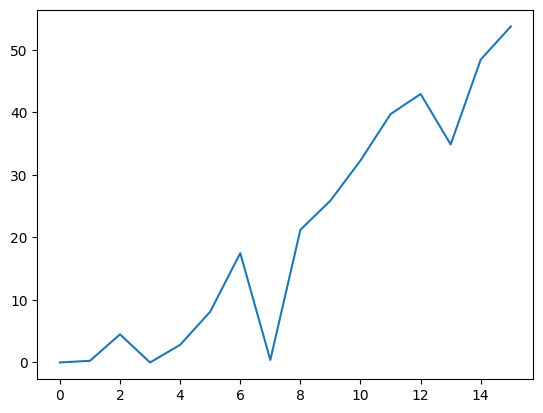

In [32]:
# quick plot of yield vs. Iteration
sobo_strategy.experiments["Yield"].plot()

# Your next task

Can you extend this code to the multi-objective case?


## multi-objective BO

In [33]:
from bofire.data_models.objectives.api import MinimizeObjective
from bofire.data_models.strategies.api import MoboStrategy
from bofire.data_models.acquisition_functions.api import qEHVI

max_objective = MaximizeObjective(w=1.0)
min_objective = MinimizeObjective(w=1.0, bounds=[0, 200])

yield_feature = ContinuousOutput(key="Yield", objective=max_objective)
ton_feature = ContinuousOutput(key="TON", objective=min_objective)
# create an output feature
output_features = Outputs(features=[yield_feature, ton_feature])
domain = Domain(
    inputs=input_features,
    outputs=output_features,
)
# a multi objective BO strategy

qExpectedImprovement = qEHVI()
mobo_strategy_data_model = MoboStrategy(
    domain=domain,
    acquisition_function=qExpectedImprovement,
)

# map the strategy data model to the actual strategy that has functionality
mobo_strategy = strategies.map(mobo_strategy_data_model)

In [34]:
# a random strategy
from bofire.data_models.strategies.api import (
    RandomStrategy as RandomStrategyModel,
)

random_strategy_model = RandomStrategyModel(domain=domain)
# we have to provide the strategy with our optimization problem so it knows where to sample from.
random_strategy = strategies.map(random_strategy_model)
candidates = random_strategy.ask(5)
experiments = util.evaluate_candidates(candidates)
mobo_strategy.tell(experiments, replace=True, retrain=True)

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/skorch/net.py:2395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

In [35]:
experimental_budget = 10
i = 0
done = False

while not done:
    i += 1
    t1 = time.time()
    # ask for a new experiment
    new_candidate = mobo_strategy.ask(1)
    new_experiment = util.evaluate_candidates(new_candidate)
    mobo_strategy.tell(new_experiment)
    print(f"Iteration took {(time.time()-t1):.2f} seconds")
    # inform the strategy about the new experiment
    # experiments = pd.concat([experiments,new_experiment],ignore_index=True)
    if i > experimental_budget:
        done = True

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/acquisition/multi_objective/monte_carlo.py:203: NumericsWarning: qExpectedHypervolumeImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedHypervolumeImprovement 	 --> 	 qLogExpectedHypervolumeImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/skorch/net.py:2395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.

Iteration took 107.50 seconds


/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/acquisition/multi_objective/monte_carlo.py:203: NumericsWarning: qExpectedHypervolumeImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedHypervolumeImprovement 	 --> 	 qLogExpectedHypervolumeImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/skorch/net.py:2395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.

Iteration took 111.85 seconds


/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/acquisition/multi_objective/monte_carlo.py:203: NumericsWarning: qExpectedHypervolumeImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedHypervolumeImprovement 	 --> 	 qLogExpectedHypervolumeImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/skorch/net.py:2395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.

Iteration took 98.47 seconds


/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/acquisition/multi_objective/monte_carlo.py:203: NumericsWarning: qExpectedHypervolumeImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedHypervolumeImprovement 	 --> 	 qLogExpectedHypervolumeImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/skorch/net.py:2395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.

Iteration took 58.26 seconds


/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/acquisition/multi_objective/monte_carlo.py:203: NumericsWarning: qExpectedHypervolumeImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedHypervolumeImprovement 	 --> 	 qLogExpectedHypervolumeImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


KeyboardInterrupt: 

In [ ]:
mobo_strategy.experiments["Yield"].plot()

In [ ]:
mobo_strategy.experiments["TON"].plot()